# NLP spacy + LSTM Sentiment Analysis of Amazon Product Reviews 
# Overview
This is a project of tagging "good" or "bad" Amazon product reviews (binary classification). The word embedding vectors are using state-of-the-art NLP product [spaCy](https://spacy.io/models/) and LSTM. 

What's learned?
* Decoding binary files directly into strings
* Parsing sentences into list of words, the "truncated" word sequence is then fed into LSTM.
* Train many-to-one Bidirectional LSTM using spaCy frozen embeddings as Embedding layers, and a TimeDistributed Dense layer.
* Small mini-batches converges faster!

# Data
The [data](https://www.kaggle.com/bittlingmayer/amazonreviews) is downloaded from Kaggle, and data cleaning and preprocessing uses the codes modified from the [kernel by Anshul Rai](https://www.kaggle.com/anshulrai/cudnnlstm-implementation-93-7-accuracy). 


In [65]:
#import SentimentAnalyser # spaCy
from deep_learning_keras import SentimentAnalyser
from deep_learning_keras import get_features
#import plac # reads in command line arguments via plac.call()
#import random
#import pathlib
#import cytoolz
#import thinc.extra.datasets
#from spacy.compat import pickle
import spacy
import numpy as np 
import pandas as pd 
import bz2
import gc # garbage collector, release unused memory
import chardet
import re
import os
print(os.listdir("./input"))
from keras.models import Model, Sequential, model_from_json
from keras.layers import LSTM, Dense, Embedding, Bidirectional, TimeDistributed, Input, Conv1D, GlobalMaxPool1D, Dropout, concatenate, Layer, InputSpec, CuDNNLSTM
from keras.optimizers import Adam
#from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import activations, initializers, regularizers, constraints
from keras.utils.conv_utils import conv_output_length
from keras.regularizers import l2
from keras.constraints import maxnorm



['test.ft.txt.bz2', 'train.ft.txt.bz2', 'amazonreviews.zip']


Read in the train and test binary datasets:

In [102]:
train_file = bz2.BZ2File('./input/train.ft.txt.bz2')
test_file = bz2.BZ2File('./input/test.ft.txt.bz2')

Decoding binary files directly into a list of strings:

In [6]:
def readbinary2list(file): 
    lines = file.readlines()
    lines = [line.decode('utf-8') for line in lines]
    labels = [0 if line.split(' ')[0] == '__label__1' else 1 for line in lines]
    sentences = [line.split(' ', 1)[1][:-1].lower() for line in lines]
    for i in range(len(sentences)):
        sentences[i] = re.sub('\d','0',sentences[i])
        if 'www.' in sentences[i] or 'http:' in sentences[i] or 'https:' in sentences[i] or '.com' in sentences[i]:
            sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", sentences[i])    
    return labels, sentences

In [103]:
test_labels,test_sentences = readbinary2list(test_file)
train_labels,train_sentences = readbinary2list(train_file)

Checkout how the labels and product review sentences look like:

In [41]:
i=0
print('label: %s \n\nsentences: \n%s\n'%(train_labels[i],train_sentences[i]))

i=6
print('label: %s \n\nsentences: \n%s\n'%(train_labels[i],train_sentences[i]))

label: 1 

sentences: 
stuning even for the non-gamer: this sound track was beautiful! it paints the senery in your mind so well i would recomend it even to people who hate vid. game music! i have played the game chrono cross but out of all of the games i have ever played it has the best music! it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. it would impress anyone who cares to listen! ^_^

label: 0 

sentences: 
buyer beware: this is a self-published book, and if you want to know why--read a few paragraphs! those 0 star reviews must have been written by ms. haddon's family and friends--or perhaps, by herself! i can't imagine anyone reading the whole thing--i spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. it is most definitely bad enough to be entered into some kind of a "worst book" contest. i can't believe amazon even sells this kind of thing. maybe i can offer

In [54]:
#gc.collect() # free memory
maxlen = 100

Load spaCy word embedding vectors, and parse the strings into a list of word sequences:

In [77]:
def get_embeddings(vocab):
    return vocab.vectors.data

nlp = spacy.load('/usr/local/lib/python3.5/site-packages/spacy/data/en_core_web_lg/en_core_web_lg-2.0.0')
try:
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
except:
    print('Sentencizer already loaded')
nsamp_train = 50000
nsamp_dev = round(nsamp_train/8)
embeddings = get_embeddings(nlp.vocab)


In [78]:
print("Parsing texts...")
nsamp_dev = round(nsamp_train/8)
train_docs = list(nlp.pipe(train_sentences[0:nsamp_train])) # makes a list of reviews, e.g., train_doc[0] contains the 1st review with texts separated into
dev_docs   = list(nlp.pipe(test_sentences[0:nsamp_dev])) # makes a list of reviews, e.g., train_doc[0] contains the 1st review with texts separated into

train_labels = np.asarray(train_labels[0:nsamp_train], dtype='int32')
dev_labels   = np.asarray(test_labels[0:nsamp_dev], dtype='int32')

test_docs   = list(nlp.pipe(test_sentences[nsamp_dev:]))
test_labels   = np.asarray(test_labels[nsamp_dev:], dtype='int32')

Parsing texts...


In [113]:
test_docs   = list(nlp.pipe(test_sentences[nsamp_dev:2*nsamp_dev]))
test_labels   = np.asarray(test_labels[nsamp_dev:2*nsamp_dev], dtype='int32')


In [114]:
test_X = get_features(test_docs, maxlen)

Map all the texts in the sentences into unique integers/features:

In [79]:
train_X = get_features(train_docs, maxlen) 
dev_X = get_features(dev_docs, maxlen)
test_X = get_features(test_docs, maxlen)

In [111]:
print('input dim (batch size, sequence length) = %s'%str(train_X.shape))

input dim (batch size, sequence length) = (50000, 100)


# Build model and run

In [80]:
def compile_lstm(embeddings, shape, settings):
    model = Sequential()
    model.add(
        Embedding(
            embeddings.shape[0],
            embeddings.shape[1],
            input_length=shape['max_length'],
            trainable=False, # don't train spaCy embedding weights
            weights=[embeddings],
            mask_zero=True
        )
    )
    model.add(TimeDistributed(Dense(shape['nr_hidden'], use_bias=False)))
    model.add(Bidirectional(LSTM(shape['nr_hidden'],
                                 recurrent_dropout=settings['dropout'], # drop node fraction for the recurrent state.
                                 dropout=settings['dropout']))) # drop node fraction for the inputs.
    model.add(Dense(shape['nr_class'], activation='sigmoid'))
    model.compile(optimizer=Adam(lr=settings['lr']), loss='binary_crossentropy', metrics=['accuracy'])
    return model
nr_hidden=64
max_length=100
dropout=0.5
learn_rate=0.001
nb_epoch=5
batch_size=32 # idk why spaCy sets mini-batch = 256 here, the paper says ideally SGD works best between 2 to 32 

shape = {'nr_hidden': nr_hidden, 'max_length': max_length, 'nr_class': 1}
settings = {'dropout': dropout, 'lr': learn_rate}
model = compile_lstm(embeddings, shape, settings)


In [105]:
model.fit(train_X, train_labels, validation_data=(dev_X, dev_labels), epochs=nb_epoch, batch_size=batch_size)

Train on 50000 samples, validate on 6250 samples
Epoch 1/5
50000/50000 [==============================] - 189s 4ms/step - loss: 0.4131 - acc: 0.8111 - val_loss: 0.3166 - val_acc: 0.8630
Epoch 2/5
50000/50000 [==============================] - 162s 3ms/step - loss: 0.3254 - acc: 0.8598 - val_loss: 0.2844 - val_acc: 0.8794
Epoch 3/5
50000/50000 [==============================] - 130s 3ms/step - loss: 0.2937 - acc: 0.8780 - val_loss: 0.2624 - val_acc: 0.8931
Epoch 4/5
50000/50000 [==============================] - 138s 3ms/step - loss: 0.2802 - acc: 0.8837 - val_loss: 0.2630 - val_acc: 0.8952
Epoch 5/5
50000/50000 [==============================] - 122s 2ms/step - loss: 0.2674 - acc: 0.8896 - val_loss: 0.2618 - val_acc: 0.8968


Notice training on small mini-batches (<32 samples) prevents SGD to be stuck at local minima and accelerates convergence according to the [paper](https://arxiv.org/abs/1804.07612).

In [106]:
model.save('model-5.h5')

# Prediction
Test case of 6250 samples prediction:

In [160]:
label_pred = model.predict(test_X)

In [197]:
import tensorflow as tf

sess = tf.Session()
threshold = [0.5]#np.arange(0,1,0.1)
y_pred = tf.constant(np.asarray([i[0]>threshold for i in label_pred]).reshape((-1,)),dtype=tf.int64)
y_true = tf.constant(test_labels,dtype=tf.int64)
_, precision = tf.metrics.precision_at_thresholds(y_true, y_pred, threshold) # mean average precision 
_, recall = tf.metrics.recall_at_thresholds(y_true, y_pred, threshold) # mean average precision 
#_, m_ap = tf.metrics.average_precision_at_k(y_true, y_pred, 10) # mean average precision for top 5 predictions, AP@k is: sum k=1:x of (precision at k * change in recall at k)
sess.run(tf.local_variables_initializer())
precision = sess.run(precision)[0]
recall = sess.run(recall)[0]
#mAP = sess.run(m_ap)
F1 = 2*precision*recall/(precision+recall)
#print('mAP = %s'%mAP)
print('recall    = %s'%recall)
print('precision = %s'%precision)
print('F1 score  = %s'%F1)

recall    = 0.86244404
precision = 0.92550635
F1 score  = 0.8928630715069191


For a threshold of 0.5, the scores are not bad considering training on my macbook air!

Let's look at the ROC curve and the area under ROC curve:

Area Under ROC curve = 0.9615417816618783


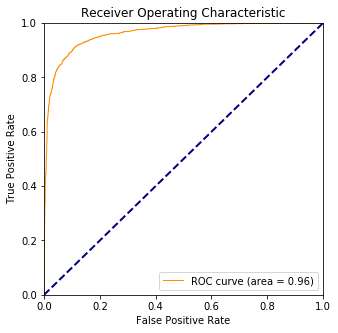

In [205]:
import sklearn
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib import pyplot as plt
area_under_roc = sklearn.metrics.roc_auc_score(test_labels,label_pred) 
print('Area Under ROC curve = %s'%area_under_roc)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_labels,label_pred)
roc_auc = sklearn.metrics.auc(fpr, tpr) # Area Under ROC Curve

#plt.figure()
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
# ROC considers all thresholds of probabilities to plot the yellow curve
# suppose at FPR=0.1, the TPR=0.9
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

# Summary
The simple test of forecast shows small sample training (50,000) achieving pretty good result on a laptop using spaCy word embeddings! 

Further comparison with [TextBlob's](https://textblob.readthedocs.io/en/dev/index.html) "polarity" function might be interesting since it's build on state-of-the-art `NLTK` model.

# Reference
* [small mini batches are good according to this paper!](https://arxiv.org/abs/1804.07612)
* [embedding layer keras](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)
* [cuDNNLSTM keras doc](https://keras.io/layers/recurrent/)
* [cuDNNLSTM implement project](https://www.kaggle.com/anshulrai/cudnnlstm-implementation-93-7-accuracy)
* [spaCy sentiment git](https://github.com/explosion/spaCy/blob/master/examples/deep_learning_keras.py)
* [spaCy](https://spacy.io/models/)
* [Python kaggle docker](https://github.com/Kaggle/docker-python/blob/master/Dockerfile)
* [TextBlob](https://textblob.readthedocs.io/en/dev/index.html)